# PART A: No Container

# Installs & Imports

In [ ]:
!pip install -q ucimlrepo seaborn scikit-learn joblib gunicorn

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import io
import joblib
from ucimlrepo import fetch_ucirepo
import sagemaker
import boto3
import flask
import gunicorn
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LinearRegression
from sagemaker import get_execution_role, LinearLearner, Session
from sagemaker import LinearLearner
from sagemaker.inputs import TrainingInput
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer
from sagemaker.image_uris import retrieve
from sagemaker.amazon.common import write_numpy_to_dense_tensor
from sagemaker.sklearn.estimator import SKLearn
from sagemaker.sklearn.model import SKLearnModel

In [37]:
# Print versions of libraries
print("Scikit-Learn:", sklearn.__version__)
print("NumPy:", np.__version__)
print("Pandas:", pd.__version__)
print("Joblib:", joblib.__version__)
print("flask:", flask.__version__)
print("gunicorn", gunicorn.__version__)
print("SageMaker SDK:", sagemaker.__version__)
print("Boto3:", boto3.__version__)

import platform
print("Python:", platform.python_version())

Scikit-Learn: 1.2.1
NumPy: 1.26.3
Pandas: 2.1.4
Joblib: 1.3.2
flask: 3.0.1
gunicorn 21.2.0
SageMaker SDK: 2.198.1
Boto3: 1.28.64
Python: 3.10.13


/tmp/ipykernel_8554/198084165.py:6: DeprecationWarning: The '__version__' attribute is deprecated and will be removed in Flask 3.1. Use feature detection or 'importlib.metadata.version("flask")' instead.
  print("flask:", flask.__version__)


# Loading the Data

In [61]:
# Load the dataset
wine_ds = fetch_ucirepo(id=186)

X = wine_ds.data.features
y = wine_ds.data.targets

In [62]:
# View the data
X.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4


# Preparing the Data

In [63]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [64]:
# Print the shapes
print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}\n")

print(f"X_test: {X_test.shape}")
print(f"y_test: {y_test.shape}")

X_train: (5197, 11)
y_train: (5197, 1)

X_test: (1300, 11)
y_test: (1300, 1)


In [65]:
# Save the training and test DataFrames locally
X_train.to_csv("wine_train_features.csv", header=False, index=False)
y_train.to_csv("wine_train_labels.csv", header=False, index=False)
               
X_test.to_csv("wine_test_features.csv", header=False, index=False)
y_test.to_csv("wine_test_labels.csv", header=False, index=False)

# Uploading Data to S3

In [66]:
# Initialize a SageMaker session
boto_session = boto3.Session(region_name='us-east-1')
session = sagemaker.Session(boto_session=boto_session)
bucket = session.default_bucket()
prefix = 'sagemaker/wine-quality'

# Upload the training data to S3
training_input_features_path = session.upload_data("wine_train_features.csv", bucket=bucket, key_prefix=f"{prefix}/train")
training_input_labels_path = session.upload_data("wine_train_labels.csv", bucket=bucket, key_prefix=f"{prefix}/train")

# Upload the test data to S3
test_input_features_path = session.upload_data("wine_test_features.csv", bucket=bucket, key_prefix=f"{prefix}/test")
test_input_labels_path = session.upload_data("wine_test_labels.csv", bucket=bucket, key_prefix=f"{prefix}/test")

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


# Model Training

In [10]:
%%writefile script.py

import argparse
import os
import joblib
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Model function
def model_fn(model_dir):
    clf = joblib.load(os.path.join(model_dir, 'model.joblib'))
    return clf

if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    
    # SageMaker parameters
    parser.add_argument('--output-data-dir', type=str, default=os.environ['SM_OUTPUT_DATA_DIR'])
    parser.add_argument('--model-dir', type=str, default=os.environ['SM_MODEL_DIR'])
    parser.add_argument('--train_features', type=str, default=os.environ['SM_CHANNEL_TRAIN_FEATURES'])
    parser.add_argument('--train_labels', type=str, default=os.environ['SM_CHANNEL_TRAIN_LABELS'])

    args = parser.parse_args()
    
    # Load datasets
    X_train = pd.read_csv(os.path.join(args.train_features, 'wine_train_features.csv'), header=None)
    y_train = pd.read_csv(os.path.join(args.train_labels, 'wine_train_labels.csv'), header=None)

    # Convert to NumPy arrays
    X_train = X_train.to_numpy()
    y_train = y_train.to_numpy()

    # Create a pipeline
    model = make_pipeline(
        StandardScaler(),
        LinearRegression()
    )
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Save the model
    joblib.dump(model, os.path.join(args.model_dir, 'model.joblib'))

Overwriting script.py


In [11]:
# Define the SKLearn Estimator
role = sagemaker.get_execution_role()
sklearn_estimator = SKLearn(entry_point='script.py',
                            role=role,
                            instance_type='ml.m4.xlarge',
                            framework_version='1.2-1',
                            py_version='py3',
                            script_mode=True,
                            sagemaker_session=session)

# Fit the model
sklearn_estimator.fit({'train_features': training_input_features_path, 'train_labels': training_input_labels_path})

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml
Using provided s3_resource


INFO:sagemaker:Creating training-job with name: sagemaker-scikit-learn-2024-02-23-04-02-37-945


2024-02-23 04:02:38 Starting - Starting the training job......
2024-02-23 04:03:24 Starting - Preparing the instances for training............
2024-02-23 04:05:14 Downloading - Downloading input data...
2024-02-23 04:05:42 Downloading - Downloading the training image...
2024-02-23 04:06:33 Training - Training image download completed. Training in progress...2024-02-23 04:06:45,585 sagemaker-containers INFO     Imported framework sagemaker_sklearn_container.training
2024-02-23 04:06:45,589 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2024-02-23 04:06:45,592 sagemaker-training-toolkit INFO     No Neurons detected (normal if no neurons installed)
2024-02-23 04:06:45,610 sagemaker_sklearn_container.training INFO     Invoking user training script.
2024-02-23 04:06:45,879 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2024-02-23 04:06:45,882 sagemaker-training-toolkit INFO     No Neurons detected (normal if no neurons 

# Model Deployment

In [12]:
# Create model from S3 artifacts
sklearn_estimator.latest_training_job.wait(logs='None')

artifact = boto3.client('sagemaker', region_name='us-east-1').describe_training_job(
    TrainingJobName=sklearn_estimator.latest_training_job.name
)['ModelArtifacts']['S3ModelArtifacts']

print(f"Model artifact persisted at {artifact}")


2024-02-23 04:07:06 Starting - Preparing the instances for training
2024-02-23 04:07:06 Downloading - Downloading the training image
2024-02-23 04:07:06 Training - Training image download completed. Training in progress.
2024-02-23 04:07:06 Uploading - Uploading generated training model
2024-02-23 04:07:06 Completed - Training job completed
Model artifact persisted at s3://sagemaker-us-east-1-992382524312/sagemaker-scikit-learn-2024-02-23-04-02-37-945/output/model.tar.gz


In [13]:
# Initialize the model
model = SKLearnModel(
    model_data=artifact,
    role=get_execution_role(),
    entry_point='script.py',
    framework_version='1.2-1',
    sagemaker_session=session
)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


In [14]:
# Deploy the model
predictor = model.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

INFO:sagemaker:Creating model with name: sagemaker-scikit-learn-2024-02-23-04-07-28-310
INFO:sagemaker:Creating endpoint-config with name sagemaker-scikit-learn-2024-02-23-04-07-29-019
INFO:sagemaker:Creating endpoint with name sagemaker-scikit-learn-2024-02-23-04-07-29-019


------!

# Deployed Model Evaluation

In [16]:
# Make predictions on the test set
predictions = predictor.predict(X_test.to_numpy())

# Evaluate the model
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

In [19]:
# Create a DataFrame for the metrics
metrics_df = pd.DataFrame({
    'Metric': ['MSE', 'RMSE', 'MAE', 'R2'],
    'Value': [mse, rmse, mae, r2]
})
metrics_df

,Metric,Value
0,MSE,0.546696
1,RMSE,0.739389
2,MAE,0.565871
3,R2,0.259767


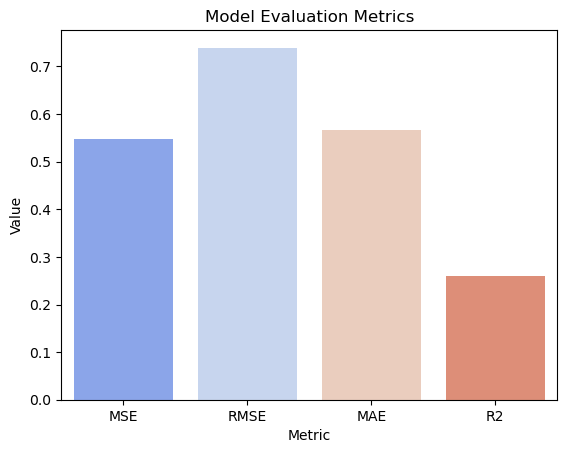

In [20]:
# Visualize the metrics
sns.barplot(x='Metric', y='Value', data=metrics_df, palette='coolwarm', hue='Metric', legend=False)
plt.title('Model Evaluation Metrics')
plt.show()

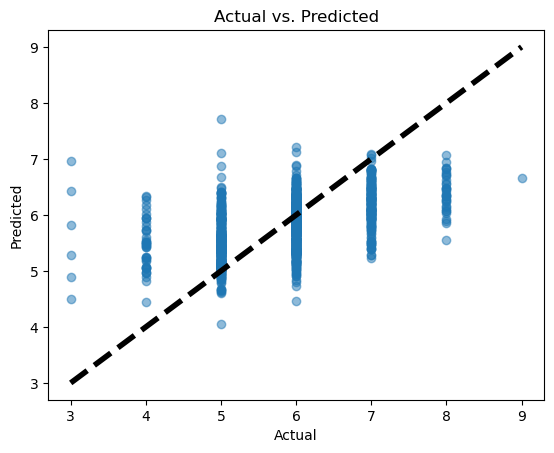

In [21]:
# Visualize actual vs. predicted values
plt.scatter(y_test, predictions, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted')
plt.show()

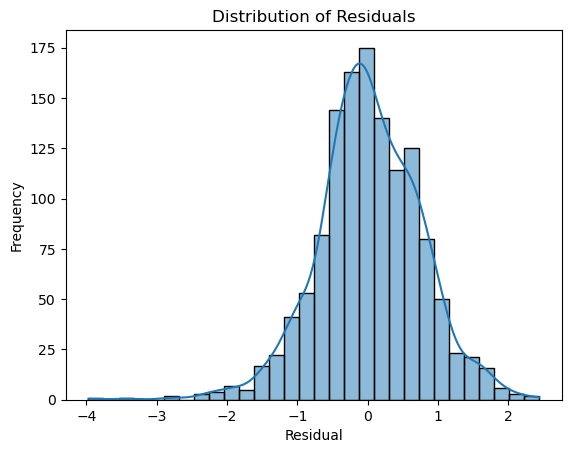

In [22]:
# Visualize the distribution of residuals
residuals = y_test - predictions
sns.histplot(residuals, kde=True, bins=30, legend=False)
plt.title('Distribution of Residuals')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.show()

# Endpoint Cleanup

In [23]:
# Cleanup
predictor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: sagemaker-scikit-learn-2024-02-23-04-07-29-019
INFO:sagemaker:Deleting endpoint with name: sagemaker-scikit-learn-2024-02-23-04-07-29-019


# PART B: With Container

# Download the Model

In [87]:
import tarfile

# Initialize a S3 client
s3_client = boto3.client('s3')

# S3 path (from Training Jobs output details)
artifact_path = 's3://sagemaker-us-east-1-992382524312/sagemaker-scikit-learn-2024-02-23-04-02-37-945/output/model.tar.gz'

# Parse the S3 path to get bucket and object key
bucket, key = artifact_path.replace("s3://", "").split("/", 1)

# Define the local path to download the model.tar.gz file
local_tar_path = '/home/sagemaker-user/model.tar.gz'

# Download the model artifact from S3 to the local path
s3_client.download_file(bucket, key, local_tar_path)

# Extract the tar.gz file
with tarfile.open(local_tar_path) as tar:
    tar.extractall(path='/home/sagemaker-user')

print("Model artifact downloaded and extracted.")

Model artifact downloaded and extracted.


In [88]:
# Load the model from the .joblib file
model = joblib.load('/home/sagemaker-user/model.joblib')

# Save the model as a .pkl file
joblib.dump(model, '/home/sagemaker-user/model.pkl')

print("Model saved as .pkl file.")

Model saved as .pkl file.


In [89]:
# Print the model
print(model)

# Print parameters
print(model.get_params())

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())])
{'memory': None, 'steps': [('standardscaler', StandardScaler()), ('linearregression', LinearRegression())], 'verbose': False, 'standardscaler': StandardScaler(), 'linearregression': LinearRegression(), 'standardscaler__copy': True, 'standardscaler__with_mean': True, 'standardscaler__with_std': True, 'linearregression__copy_X': True, 'linearregression__fit_intercept': True, 'linearregression__n_jobs': None, 'linearregression__positive': False}


# Model Deployment

In [90]:
import sagemaker
from sagemaker.sklearn.model import SKLearnModel
from sagemaker import get_execution_role

# Define the ECR path to the Docker image
image_uri = '992382524312.dkr.ecr.us-east-1.amazonaws.com/wine-quality-predictor:latest'

# Get the SageMaker execution role
role = get_execution_role()

# Create a SageMaker model
model = SKLearnModel(
    model_data=artifact_path,
    role=role,
    entry_point='serve.py',
    framework_version='1.2-1',
    image_uri=image_uri,
    sagemaker_session=session
)

# Deploy the model to an endpoint
predictor = model.deploy(
    initial_instance_count=1,
    instance_type='ml.m4.xlarge',
    endpoint_name='wine-quality-predictor-endpoint-final'
)

print(f'Model deployed to endpoint: {predictor.endpoint_name}')

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


INFO:sagemaker:Creating model with name: wine-quality-predictor-2024-02-23-09-07-02-326
INFO:sagemaker:Creating endpoint-config with name wine-quality-predictor-endpoint-final
INFO:sagemaker:Creating endpoint with name wine-quality-predictor-endpoint-final


---!Model deployed to endpoint: wine-quality-predictor-endpoint-final


# Testing the Endpoint

In [91]:
import json

runtime = boto3.client('runtime.sagemaker', region_name='us-east-1')

# Mock data payload
payload = {
    "inputs": [[7.8, 0.88, 0.00, 2.6, 0.098, 25.0, 67.0, 0.9968, 3.20, 0.68, 9.8]]
}

# Invoke the endpoint
response = runtime.invoke_endpoint(
    EndpointName='wine-quality-predictor-endpoint-final',
    ContentType='application/json',
    Body=json.dumps(payload)
)

# Parse the response
response_body = json.loads(response['Body'].read().decode('utf-8'))
print(f"Predicted Wine Quality: {response_body[0][0]}")

Predicted Wine Quality: 4.92206518931702


# Endpoint Cleanup

In [92]:
# Cleanup
predictor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: wine-quality-predictor-endpoint-final
INFO:sagemaker:Deleting endpoint with name: wine-quality-predictor-endpoint-final
